In [1]:
#%reload_ext dotenv
#%dotenv

# ML libraries
import torch
import torch.nn as nn

# Local imports
from env import Env
from trainer import Trainer
import utils
# Training Agents
from agents.cql_agent import CQLAgent
from agents.deep_q_agent import DeepQAgent
from agents.deep_q_agent_double_q import DDQAgent
# Non-Training Agents
from agents.minimax_agent import MinimaxAgent
from agents.random_agent import RandomAgent

In [2]:
##################
# INITIALIZATION #
##################

# Tweek these parameters for training and evaluation
num_episodes = {'TRAIN': 2000, 'EVAL': 100}
with_options = False
# Agent
agent_type = 'DDQAgent'                # DDQAgent, DeepQAgent, CQLAgent
agent_network_type = 'FCNN'            # CNN, FCNN
# Opponent
opponent_type = 'MinimaxAgent'         # DDQAgent, DeepQAgent, CQLAgent, MinimaxAgent, RandomAgent
opponent_network_type = 'CNN'          # CNN, FCNN
minimax_depth = 2
minimax_epsilon = 0.3
# Same for both agent and opponent
epsilon_max = 1
epsilon_min = 0.01
epsilon_decay = 0.9997

# Fix random seed
utils.seed_everything(43, deterministic=False)

# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define player and opponent IDs
AGENT = 1
OPPONENT = 2

# Define game environment, this should be passed to the agents and the trainer
env = Env()

# Define agent
if agent_type == 'DDQAgent':
    agent = DDQAgent(env=env, epsilon_max=epsilon_max, epsilon_min=epsilon_min, epsilon_decay=epsilon_decay, network_type=agent_network_type, device=device)
elif agent_type == 'DeepQAgent':
    agent = DeepQAgent(env=env, epsilon_max=epsilon_max, epsilon_min=epsilon_min, epsilon_decay=epsilon_decay, network_type=agent_network_type, device=device)
elif agent_type == 'CQLAgent':
    agent = CQLAgent(env=env, epsilon_max=epsilon_max, epsilon_min=epsilon_min, epsilon_decay=epsilon_decay, network_type=agent_network_type, device=device)
else:
    raise ValueError(f"Unknown agent_type: {agent_type}")
# Define opponent
if opponent_type == 'DDQAgent':
    opponent = DDQAgent(env=env, epsilon_max=epsilon_max, epsilon_min=epsilon_min, epsilon_decay=epsilon_decay, network_type=opponent_network_type, device=device)
elif opponent_type == 'DeepQAgent':
    opponent = DeepQAgent(env=env, epsilon_max=epsilon_max, epsilon_min=epsilon_min, epsilon_decay=epsilon_decay, network_type=opponent_network_type, device=device)
elif opponent_type == 'CQLAgent':
    opponent = CQLAgent(env=env, epsilon_max=epsilon_max, epsilon_min=epsilon_min, epsilon_decay=epsilon_decay, network_type=opponent_network_type, device=device)
elif opponent_type == 'MinimaxAgent':
    opponent = MinimaxAgent(env=env, depth=minimax_depth, epsilon=minimax_epsilon, player=OPPONENT)
elif opponent_type == 'RandomAgent':
    opponent = RandomAgent(env=env)
else:
    raise ValueError(f"Unknown opponent_type: {opponent_type}")

# Define options for training
replacement_agent = None
options = {
           'UPDATE_OPPONENT': False,                         # Whether to enable self-play or not
           'OPPONENT_UPDATE_FREQUENCY': 100,                # After how many episodes the opponent will be replaced by the current agent
           'BOOTSTRAP_EPISODES': 7500,                      # During this time, the agent will not be replaced by itself
           'DECAY_RANDOMNESS_OPPONENT': False,              # Decay randomness of the opponent. Use only if the opponent acts with some randomness
           'DECAY_RANDOMNESS_FREQUENCY': 1000,              # Frequency of randomness decay
           'REPLACE_FOR_EVALUATION': False,                  # Whether to replace the training model at the end with another evaluation model
           'REPLACE_FOR_EVALUATION_BY': replacement_agent,  # Evalutation model to replace training model by
           'AUTOSAVE': True,                                # Whether to save the model at certain intervals
           'AUTOSAVE_TYPE': 'NUM_EPISODES',                 # One of ["NUM_OPTIMIZATIONS", "NUM_EPISODES"]
           'AUTOSAVE_PERIOD': 1000,                         # After how many _ to save the model
           }
if not with_options: options = None

# Initialize trainer
trainer = Trainer(env=env, agent=agent, opponent=opponent, agent_id=AGENT, opponent_id=OPPONENT, num_episodes=num_episodes, device=device, verbose=True, options=options)

TRAIN: Running episode 2000 of 2000. Agent won 106 times. Current win ratio of AGENT is 5.30%. Agent Parameters: Epsilon = 0.031191, Memory Size = 10000
TRAIN: Average turns per episode 5.882
TRAIN: Average invalid moves per episode 0.0


Plotting Episode rewards and steps...


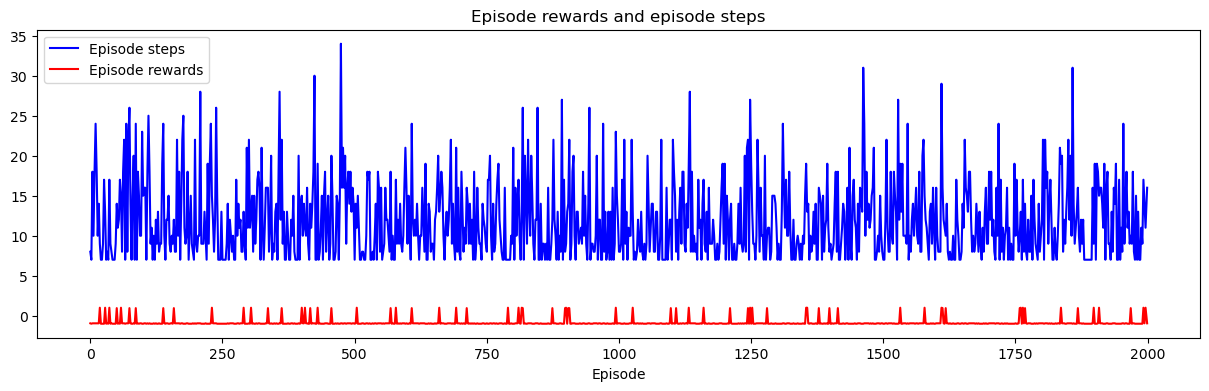

Model was saved in ./saved_models/ as DDQAgent_FCNN_11565.pt
EVAL: Running episode 100 of 100. Agent won 5 times. Current win ratio of AGENT is 5.00%. Agent Parameters: Epsilon = 0.031116, Memory Size = 10000    
EVAL: Average turns per episode 6.25
EVAL: Average invalid moves per episode 0.0


Plotting Episode rewards and steps...


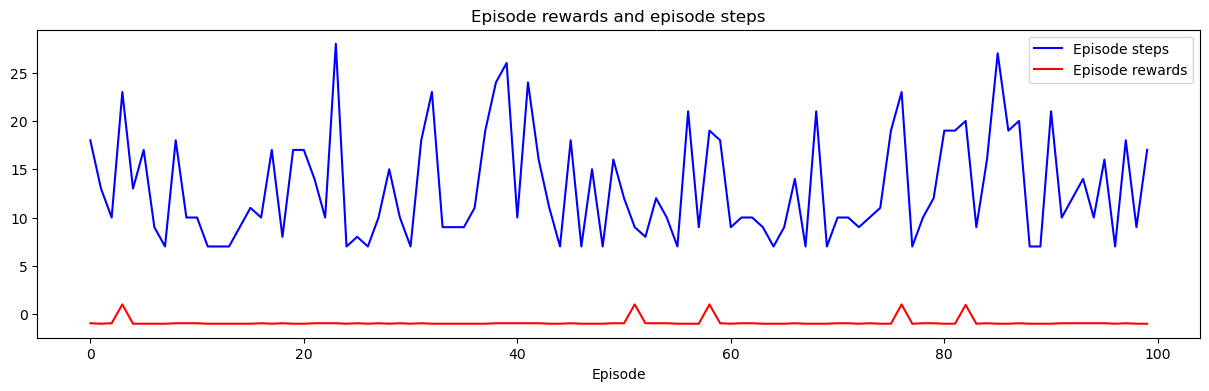

In [3]:
############
# TRAINING #
############

# Train agent
trainer.train()

Evaluating: CQLAgent_CNN_RS43.pt vs. CQLAgent_CNN_RS43.pt
EVAL: Running episode 1 of 1000. Ratios are [WINS: 100.00% | LOSSES: 0.00% | TIES: 0.00%]

EVAL: Running episode 1000 of 1000. Ratios are [WINS: 49.90% | LOSSES: 50.10% | TIES: 0.00%]
EVAL: Average turns per episode 8.992
EVAL: Average invalid moves per episode 0.0


Plotting Episode rewards and steps...


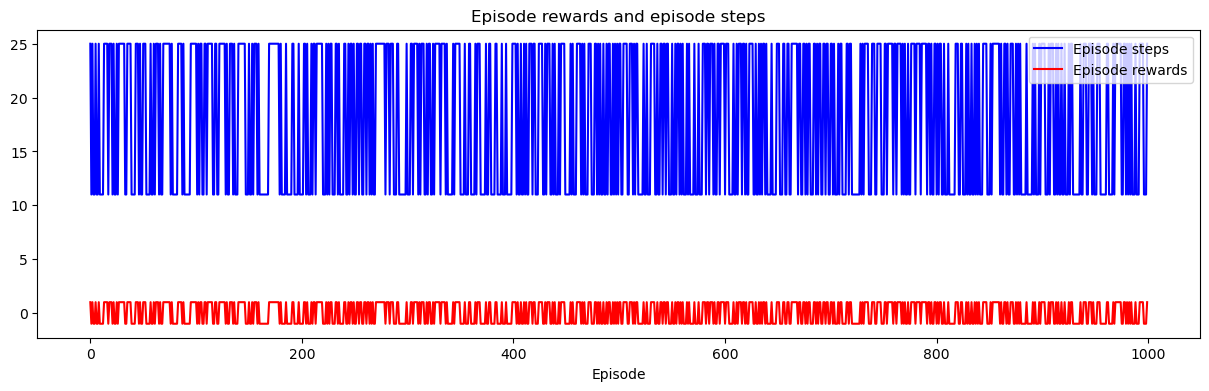

In [117]:
####################
# AGENT EVALUATION #
####################

# Tweek these parameters for evaluation
episodes = 1000
# Agent
agent_type = 'CQLAgent'                 # DDQAgent, DeepQAgent, CQLAgent, MinimaxAgent, RandomAgent
agent_network_type = 'CNN'              # CNN, FCNN
# Opponent
opponent_type = 'CQLAgent'              # DDQAgent, DeepQAgent, CQLAgent, MinimaxAgent, RandomAgent
opponent_network_type = 'CNN'           # CNN, FCNN
minimax_depth = 2
minimax_epsilon = 0.3
epsilon_max = 1
epsilon_min = 0.01
epsilon_decay = 0.9997

# Set random seed value (we chose 41, 42 and 43)
random_seed_nr = 43

# You don't need to change anything below here for evaluation

# Fix random seed
utils.seed_everything(random_seed_nr, deterministic=False)

# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define player and opponent IDs
AGENT = 1
OPPONENT = 2

eval_env = Env()

# Load agent from save and set to eval mode
if agent_type == 'DDQAgent':
    agent = DDQAgent(env=eval_env, epsilon_max=epsilon_max, epsilon_min=epsilon_min, epsilon_decay=epsilon_decay, network_type=agent_network_type, device=device)
elif agent_type == 'DeepQAgent':
    agent = DeepQAgent(env=eval_env, epsilon_max=epsilon_max, epsilon_min=epsilon_min, epsilon_decay=epsilon_decay, network_type=agent_network_type, device=device)
elif agent_type == 'CQLAgent':
    agent = CQLAgent(env=eval_env, epsilon_max=epsilon_max, epsilon_min=epsilon_min, epsilon_decay=epsilon_decay, network_type=agent_network_type, device=device)
elif agent_type == 'MinimaxAgent':
    agent = MinimaxAgent(env=eval_env, depth=minimax_depth, epsilon=minimax_epsilon, player=AGENT)
elif agent_type == 'RandomAgent':
    agent = RandomAgent(env=eval_env)
else:
    raise ValueError(f"Unknown agent_type: {agent_type}")

# Define opponent
if opponent_type == 'DDQAgent':
    opponent = DDQAgent(env=eval_env, epsilon_max=epsilon_max, epsilon_min=epsilon_min, epsilon_decay=epsilon_decay, network_type=opponent_network_type, device=device)
elif opponent_type == 'DeepQAgent':
    opponent = DeepQAgent(env=eval_env, epsilon_max=epsilon_max, epsilon_min=epsilon_min, epsilon_decay=epsilon_decay, network_type=opponent_network_type, device=device)
elif opponent_type == 'CQLAgent':
    opponent = CQLAgent(env=eval_env, epsilon_max=epsilon_max, epsilon_min=epsilon_min, epsilon_decay=epsilon_decay, network_type=opponent_network_type, device=device)
elif opponent_type == 'MinimaxAgent':
    opponent = MinimaxAgent(env=eval_env, depth=minimax_depth, epsilon=minimax_epsilon, player=OPPONENT)
elif opponent_type == 'RandomAgent':
    opponent = RandomAgent(env=eval_env)
else:
    raise ValueError(f"Unknown opponent_type: {opponent_type}")

agent_string = f"{agent_type}_{agent_network_type}_RS{random_seed_nr}.pt" if agent_type in ['DDQAgent', 'CQLAgent', 'DeepQAgent'] else None
opponent_string = f"{opponent_type}_{opponent_network_type}_RS{random_seed_nr}.pt" if opponent_type in ['DDQAgent', 'CQLAgent', 'DeepQAgent'] else None

# Load pretrained models
if agent_type in ['DDQAgent', 'CQLAgent', 'DeepQAgent']:
    agent.load_model(f'./saved_models/{agent_string}')
if opponent_type in ['DDQAgent', 'CQLAgent', 'DeepQAgent']:
    opponent.load_model(f'./saved_models/{opponent_string}')

# Initialize trainer
trainer = Trainer(env=eval_env, agent=agent, opponent=opponent, agent_id=AGENT, opponent_id=OPPONENT, device=device, verbose=True)

# Run evaluation
print(f"Evaluating: {agent_string if agent_string else agent_type} vs. {opponent_string if opponent_string else opponent_type}")
trainer.eval(agent=agent, opponent=opponent, episodes=episodes, agent_start=None, print_last_n_games=0)